In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss

import logging
logger = logging.getLogger('qick.qick_asm')
logger.setLevel(logging.ERROR)

from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import InstrumentManager
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amprabi_opt_ctrl_state_prep
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.crosstalk_echo_calib
imp

# State tomography analysis functions

Measurement occurs along 3^3=27 axes, each of which can give one of 2^3=8 values

## Basis definitions

In [4]:
meas_order = meas.three_qubit.threeQ_state_tomo.make_3q_meas_order()
calib_order = meas.three_qubit.threeQ_state_tomo.make_3q_calib_order()

calib_order_numeric = np.zeros_like(calib_order)
for i, label in enumerate(calib_order):
    label_numeric = ''
    for char in label:
        if char == 'g': label_numeric += '0'
        elif char == 'e': label_numeric += '1'
    calib_order_numeric[i] = label_numeric

print(meas_order)
print(calib_order)
print(calib_order_numeric)

['ZZZ' 'ZZX' 'ZZY' 'ZXZ' 'ZXX' 'ZXY' 'ZYZ' 'ZYX' 'ZYY' 'XZZ' 'XZX' 'XZY'
 'XXZ' 'XXX' 'XXY' 'XYZ' 'XYX' 'XYY' 'YZZ' 'YZX' 'YZY' 'YXZ' 'YXX' 'YXY'
 'YYZ' 'YYX' 'YYY']
['ggg' 'gge' 'geg' 'gee' 'egg' 'ege' 'eeg' 'eee']
['000' '001' '010' '011' '100' '101' '110' '111']


First random helper method stuff for pauli matrices and dealing with the measurement order

In [5]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S123): # given 3 pauli matrix names, get the index at which that combo (or equivalent data) was measured
    assert S123[0] in 'IXYZ'
    assert S123[1] in 'IXYZ'
    assert S123[2] in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    for q, Sq in enumerate(S123):
        if Sq == 'I': S123 = S123[:q] + 'Z' + S123[q+1:]
    return np.argwhere(meas_order == S123)[0][0]
# print(meas_order)
# print(order('IZX'))

Define psi basis

In [6]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
# psiZ = [qt.basis(3,0), qt.basis(3,1)]
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = dict() # 27*8 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
for S123 in meas_order:
    S1, S2, S3 = S123
    psi1 = psi_dict[S1]
    psi2 = psi_dict[S2]
    psi3 = psi_dict[S3]

    psi_basis.update({S123:[]})

    for state1 in (0,1):
        for state2 in (0,1):
            for state3 in (0,1):
                psi_basis[S123].append(qt.tensor(psi1[state1], psi2[state2], psi3[state3]).unit())

psi_basis_flat = []
for S123 in meas_order:
    for psi in psi_basis[S123]:
        # measure in psi basis
        psi_basis_flat.append(psi)

## Getting rho from meas counts

Convert single shot measurements into counts for each of the 27 measurement axes: 8x27=216 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [7]:
"""
n should be length 2^q=8 array containing single shot counts of measuring 000, 001, 010, 011, ... for measurement along axes i, j, k
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S1, S2, S3: I, X, Y, Z
"""
print(calib_order)
def Tij(n, S1, S2, S3):
    assert 0 <= S1 <= 3 # Si represent pauli matrix indices
    assert 0 <= S2 <= 3
    assert 0 <= S3 <= 3
    signs = [1]*8
    S123 = [S1, S2, S3]
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1, so multiply sign by -1 if measuring in XYZ basis and measuring e
    for icalib, calib in enumerate(calib_order):
        for q in range(3):
            if S123[q] > 0 and calib[q] == 'e': signs[icalib] *= -1
    return np.sum(np.multiply(signs, n)) / np.sum(n)


['ggg' 'gge' 'geg' 'gee' 'egg' 'ege' 'eeg' 'eee']


In [8]:
"""
Construct rho by adding together Tij for each of the 4^3 = 64 combinations of tensor product of 3 Pauli matrices
Total number of matrices to add up should be d^2, d=2^n_qubits
"""
def rho_from_counts(n):
    # print('shape', n.shape)
    rho = 0*qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
    for i in range(4): # loop over pauli matrices for qubit 1
        for j in range(4): # loop over pauli matrices for qubit 1
            for k in range(4): # loop over pauli matrices for qubit 1
                o = order(i2s(i) + i2s(j) + i2s(k)) # get the right row of 8 elements in the n matrix
                # print('order', o, i, j, k)
                # print(i, j, k, 'expval', Tij(n[o:o+1], i, j, k))
                rho += Tij(n[o:o+1], i, j, k) * qt.tensor(pauli(i), pauli(j), pauli(k)) / 2**3
    # rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    rho = rho.full()
    assert np.around(np.trace(rho), 1), f'Trace of rho from counts is {np.trace(rho)}'
    return rho

## Generate test data

In [9]:
def generate_counts(rho_id, n_tot, psi_basis_flat=None, evol_mats=None, noise=1.0):
    assert psi_basis_flat or evol_mats
    
    if psi_basis_flat is not None:
        print('Generating with psi basis')
        n = []
        # psi_basis = get_psi_basis(qubits)
        for psi in psi_basis_flat:
            # measure in psi basis
            n.append(n_tot * (psi.dag() * rho_id * psi).tr())
        n = np.reshape(np.array(n), (len(psi_basis.keys()), 8))
    
    elif evol_mats is not None:
        print('Generating with evol mats')
        evals, evecs = np.linalg.eig(rho_id)
        evals = np.real(evals)
        n_evol = []
        for basis in meas_order:
            evol_mat = evol_mats[basis] # evol_mat sends each psi_ij to the evolved ket
            n_basis_th = np.zeros(8)
            for i in range(4):
                evec_evol = evol_mat @ evecs.T[i]
                if evals[i] > 1e-12: n_basis_th += evals[i] * n_tot * abs(evec_evol)**2 # add counts weighted by eval
            n_evol.append(n_basis_th)
        n_evol = np.array(n_evol)
        return n_evol

    # introduce gaussian noise
    if noise is not None:
        for n_psi in n:
            n_meas = sum(n_psi)
            new_nlast = -1
            while new_nlast < 0:
                new_n_excludelast = np.random.normal(loc=n_psi[:-1], scale=noise*np.sqrt(n_psi[:-1]))
                # preserve original total count per measurement
                new_nlast = n_meas - sum(new_n_excludelast)
            n_psi[:-1] = np.round(new_n_excludelast)
            n_psi[-1] = np.round(new_nlast)
    return n

## Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

In [10]:
from experiments.two_qubit.twoQ_state_tomography import correct_readout_err, fix_neg_counts

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions

In [11]:
# Modification of np.diag_indices to allow off diagonal entries
# n = dim, k < 0 = lower diagonals, k > 0 = upper diagonals
def diag_indices_k(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0: return rows[-k:], cols[:k]
    elif k > 0: return rows[:-k], cols[k:]
    else: return rows, cols

def T_flat2mat(t):
    d = int(np.sqrt(len(t)))
    t_complex = np.zeros(int(d + (len(t)-d)/2), dtype=complex)
    t_complex[:d] = t[:d]
    for i in range(d, len(t_complex)):
        t_complex[i] = t[d + (i-d)*2] + 1j*t[d + (i-d)*2 + 1]
    T_mat = np.zeros(shape=(d,d), dtype=complex)
    start_i = 0
    for k in range(d):
        T_mat[diag_indices_k(T_mat, -k)] = t_complex[start_i:start_i+(d-k)]
        start_i += d - k
    return np.array(T_mat)


USE THESE (need to handle divide by 0 errors, which the more general method does not handle)

This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

In [12]:
# def det_ij(rho, i, j):
#     M = np.delete(rho, i, axis=0)
#     M = np.delete(M, j, axis=1)
#     return np.linalg.det(M)

# def det_ijkl(rho, i, j, k, l):
#     M = np.delete(rho, [i,k], axis=0)
#     M = np.delete(M, [j,l], axis=1)
#     return np.linalg.det(M)

# def t_from_rho(rho):
#     t = []
#     det = np.linalg.det(rho)
#     det00 = det_ij(rho, 0, 0)
#     det01 = det_ij(rho, 0, 1)
#     det0011 = det_ijkl(rho, 0, 0, 1, 1)
#     det0012 = det_ijkl(rho, 0, 0, 1, 2)
#     det0112 = det_ijkl(rho, 0, 1, 1, 2)
#     # ensure no divide by 0 errors since this algo is intended for positive definite matrices
#     # if det == 0: det = 1e-10
#     # if det00 == 0: det00 = 1e-10
#     # if det0011 == 0: det0011 = 1e-10
#     # if det0012 == 0: det0012 = 1e-10
#     # if det0112 == 0: det0112 = 1e-10
#     rho33 = rho[3,3]
#     # if rho33 == 0: rho33 = 1e-10
#     t = [
#         0 if det00 == 0 else np.sqrt(det/det00),
#         0 if det0011 == 0 else np.sqrt(det00/det0011),
#         0 if rho33 == 0 else np.sqrt(det0011/rho33),
#         np.sqrt(rho[3,3])
#         ]
#     t56 = 0 if det00*det0011 == 0 else det01/np.sqrt(det00*det0011)
#     t.extend([np.real(t56), np.imag(t56)])

#     t78 = 0 if rho33*det0011 == 0 else det0012/np.sqrt(rho33*det0011)
#     t.extend([np.real(t78), np.imag(t78)])

#     t910 = 0 if rho33 == 0 else rho[3,2]/np.sqrt(rho33)
#     t.extend([np.real(t910), np.imag(t910)])

#     t1112 = 0 if rho33*det0011 == 0 else det0112/np.sqrt(rho33*det0011)
#     t.extend([np.real(t1112), np.imag(t1112)])

#     t1314 = 0 if rho33 == 0 else rho[3,1]/np.sqrt(rho33)
#     t.extend([np.real(t1314), np.imag(t1314)])

#     t1516 = 0 if rho33 == 0 else rho[3,0]/np.sqrt(rho33)
#     t.extend([np.real(t1516), np.imag(t1516)])

#     assert(len(t)==16)
#     return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative

# def rho_from_t(t):
#     T = T_flat2mat(t)
#     rho = T.conj().T @ T
#     return rho / np.trace(rho)

Not using this

Cholesky-Banachiewicz algorithm - valid for positive definite matrices, so need to ensure no divide by 0 errors. This doesn't seem to work?

In [13]:
def t_from_rho(rho):
    t = []
    T = np.zeros(shape=np.shape(rho))
    d = np.shape(rho)[0]
    for i in range(d):
        for j in range(i+1):
            sum = 0
            for k in range(j):
                sum += T[i, k] * T[j, k]
            if i == j: T[i, i] = np.sqrt(rho[i, i] - sum)
            else:
                Tjj = T[j, j]
                if Tjj == 0: T[i, j] = 0
                else: T[i, j] = (rho[i, j] - sum) / Tjj
    t = np.diagonal(T)
    for k in range(1, d):
        t_complex = np.diag(T, k=-k)
        for t_i in t_complex:
            t = np.append(t, [np.real(t_i), np.imag(t_i)])
    # assert(len(t)==16)
    return np.real(t)
    
def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T @ T.conj().T
    return rho / np.trace(rho)

### ZZ correction
Instead of using bare psis in MLE, introduce ZZ coupling in Hamiltonian and use the pulse shapes used in the tomography pulse sequence to simulate the expected final state of each of the psis. Then use these corrected "evolution states" to match the MLE.

Note: uses QSwitch and related classes

In [14]:
"""
Get effective drive rate in GHz
"""
sigma_n = 4 # total number of sigmas in gaussian

"""
When this amp_eff is passed as a drive amplitude to the simulation,
performs a full pi pulse when sigma_n*sigma_ns gaussian is played
"""
def amp_eff(sigma_ns, sigma_n=sigma_n):
    return 1/2 / (sigma_ns * np.sqrt(2*np.pi) * sp.special.erf(sigma_n/2 / np.sqrt(2)))

# Return what phi should be when driving in the other quadrature, i.e. cos(wt+phi) <-> sin(wt-phi)
def phase_to_other_drive(phase):
    return phase

In [15]:
def get_evol_mats(qubits, qfreqs, alphas, ZZs, pulse_dict, dt=0.001, debug=False):
    assert len(pulse_dict.items()) == len(meas_order)
    evol_mats = dict()
    device = QSwitch(qubit_freqs=qfreqs, alphas=alphas, ZZs=ZZs, cutoffs=[2,2,2], useZZs=True)

    # Get the pi/2 pulse lengths for both qubits
    pulse_cfgs_XXX = pulse_dict['XXX']
    pi2_lens = [0]*3
    pi2_types = [None]*3
    for pulse_name, pulse_cfg in pulse_cfgs_XXX.items():
        if pulse_cfg['flag'] != 'ZZcorrection': continue
        drive_qubit = int(pulse_cfg['name'][-1]) # get the qubit number
        assert drive_qubit in qubits

        # convert drive qubit out of 4 to drive qubit in a 3Q Hamiltonian
        drive_qubit = qubits.index(drive_qubit)
        pi2_types[drive_qubit] = pulse_cfg['type']
        if pi2_types[drive_qubit] == 'gauss':
            pulse_len = pulse_cfg['sigma']
        elif pi2_types[drive_qubit] == 'const':
            pulse_len = pulse_cfg['length']
        pi2_lens[drive_qubit] = soc.cycles2us(pulse_len, gen_ch=pulse_cfg['ch']) * 1e3
    assert 0 not in pi2_lens

    for basis, pulse_cfgs in tqdm(pulse_dict.items()):
        if debug: print(basis)
        
        seq = PulseSequence()

        # print('all pulse_cfgs for basis', basis, pulse_cfgs)
        for drive_qubit in (0, 1, 2):
            # For Z basis measurement, do an empty pulse so timing is the same
            if basis[drive_qubit] == 'Z':
                # if debug: print('add empty pulse on qubit', qubits[drive_qubit])
                # device.add_precise_pi_pulse(seq, 'ggg', 'ggg', amp=0, drive_qubit=drive_qubit, wd=-1, phase=0, type=pi2_types[drive_qubit], t_pulse=pi2_lens[drive_qubit], t_offset=0, sigma_n=sigma_n)
                continue

            # Find the appropriate pulse cfg for the pulse within the experiment on this basis
            for pulse_name, pulse_cfg in pulse_cfgs.items():
                # print('flag', pulse_cfg['flag'])
                if pulse_cfg['flag'] != 'ZZcorrection': continue
                # print(pulse_name)
                pulse_qubit = int(pulse_cfg['name'][-1]) # get the qubit number
                assert pulse_qubit in qubits
                # convert drive qubit out of 4 to drive qubit in a 3Q Hamiltonian, proceed if this is the drive qubit we want
                if qubits.index(pulse_qubit) != drive_qubit: continue

                ch = pulse_cfg['ch']
                freq = pulse_cfg['freq_MHz']
                freq += 4000 if freq < 1000 else 0 # qubit drive has mixer freq
                wd = 2*np.pi * freq * 1e-3
                # phase = pulse_cfg['phase_deg'] * np.pi/180
                phase = phase_to_other_drive(pulse_cfg['phase_deg'] * np.pi/180) # convert from the sin wavefunction used in definition of rfsoc drive to the cos wavefunction used for simulations
                pulse_type = pulse_cfg['type']

                pi2_sigma = pi2_lens[drive_qubit] # ns
                assert pi2_sigma > 1 # 1 ns
                
                # account for qick having a different definition of sigma in the gaussian
                pi2_sigma /= np.sqrt(2)
                sigma_n = 4*np.sqrt(2)

                # figure out whether we are dividing the length or not for the pi/2 pulse and set the flags appropriately
                # default: assume pi/2 length is pi pulse length/2
                amp = amp_eff(pi2_sigma*2, sigma_n=sigma_n) # this is the amplitude for a pi pulse
                pihalf = True # determines whether the simulation will play the gaussian for the full Tpi (False) or half Tpi (True)
                if 'X' in pulse_cfg['name'] or 'Y' in pulse_cfg['name']:
                    if 'half' not in pulse_cfg['name']: # dividing gain instead of length in the experiment pi/2 pulse
                        amp /= 2
                        pihalf = False

                new_state = 'ggg'
                new_state = new_state[:drive_qubit] + 'e' + new_state[drive_qubit+1:]
                if debug: print('add pi pulse on qubit', qubits[drive_qubit], 'with freq', freq, 'length', pi2_sigma, 'amp', amp)
                device.add_precise_pi_pulse(seq, 'ggg', new_state, amp=amp, drive_qubit=drive_qubit, wd=wd, phase=phase, type=pulse_type, t_pulse=pi2_sigma, t_offset=0, sigma_n=sigma_n)

                # # print('all params')
                # print('fd', wd/2/np.pi)
                # print('pulse length', pi2_sigma)
                # print('amp', amp)
                # print('phase rad', phase)
                # print('drive q', drive_qubit)

        total_length = seq.get_end_time()
        if total_length != 0:
            nsteps = int(total_length // dt + 1)
            times = np.linspace(0, total_length, num=nsteps)
            
            # ====== PLOT PULSE SEQUENCE ====== #
            if debug:
                envelope_seq = seq.get_envelope_seq()
                pulse_amps = seq.get_pulse_amps()
                pulse_freqs = seq.get_pulse_freqs()
                pulse_lens = seq.get_pulse_lengths()
                drive_funcs = seq.get_pulse_seq()
                envelope_v_times = []
                for i in range(len(envelope_seq)):
                    envelope_v_time = [drive_funcs[i](t)*1e3 for t in times]
                    envelope_v_times.append(envelope_v_time)
                    plt.plot(times, envelope_v_time)
                plt.xlabel('Time (ns)')
                plt.ylabel('Drive Amplitude (MHz)')
                plt.title('Pulse Sequence')
                plt.show()

        evol_mats.update({basis:[]})
        for init_state in calib_order:
            # psi0 = qt.ket(str(state0) + str(state1) + str(state2))
            psi0 = device.state(init_state)
            if total_length == 0:
                evol_ket = psi0
            else:
                evol_ket_all_times = device.evolve(psi0, seq, times, nsteps=100000, use_str_solve=False, progress=False)
                evol_ket = device.evolve_unrotate(times=[times[-1]], result=[evol_ket_all_times[-1]], progress=False)[-1]
            evol_mats[basis].append(evol_ket.unit())
            
            if not debug: continue
            print('evolution ket result')
            print(evol_ket)
            
            if total_length != 0:
                # ====== PLOT STATE EVOLUTION ====== #
                # print('from', str(state0) + str(state1) + str(state2))
                print('from', init_state)
                ref_states = calib_order
                for ref_state in ref_states:
                    state = device.state(ref_state)
                    probs = [np.abs(state.overlap(evol_ket_all_times[t]))**2 for t in range(len(times))]
                    print(ref_state, 'probabilty', probs[-1])
                    plt.plot(times, probs, label=f'$|{ref_state}\\rangle_D$')
                
                plt.legend(ncol=2)
                plt.ylim(-0.05, 1.05)
                plt.xlabel('Time (ns)')
                plt.ylabel('Probability')
                plt.grid(linewidth=0.3)
                # plt.title(f'{basis} start from {str(state0)+str(state1)+str(state2)}')
                plt.title(f'{basis} start from {init_state}')
                plt.show()
                    
        evol_mats[basis] = np.hstack(evol_mats[basis])
        
        if debug: print()

    return evol_mats

#### Constructing the expectation values in the evolved bases
If we have a perfect rotation (no ZZ): let's say we want to measure sigmax, the evals are +/-1.
During the measurement, we apply a rotation R to the state, which takes us to the sigmaz basis.
Next, we perform a projective measurement onto the Z axis.
This gives us full information about the state as if we had performed the measurement in the X axis,
but this is only true because the act of measuring projects us onto the same basis that we are getting information in.

In the ZZ correction case: let's say we are again doing the "$\sigma_x$" measurement. But now, we have a bad rotation $R'$, which takes $|X_+\rangle$ to $|Z_+ + \phi\rangle $. What we want is to get the expectation value along the modified $|X'_+\rangle$, aka measuring with operator $\tilde{\sigma}_x$. However, unlike in the perfect rotation case, because the rotation $R'$ (let's say this takes us through total angle $\theta=90+\phi$) does not take us directly from $|X_+\rangle$ to $|Z_+\rangle$, but rather from $|X_+\rangle$ to $|Z_++\phi\rangle= R'|X_+\rangle$, doing the projective measurement along the $Z$ axis (aka getting the g/e probabilities in the $Z$ axis) does NOT translate to having that same expectation value in the $X'$ axis. This can be seen in the extreme case where the ZZ is so bad that we do not perform any rotation at all: if we start in the $|X_+\rangle$ and we project onto the $Z$ axis, we would get probabilities of 50/50 for g/e, but this is not equivalent to having 50/50 population in the "g/e" of the $X$ basis.

Instead, what the measurement along the $Z+\phi$ axis tells us is NOT the expectation value of the operator $\tilde{\sigma}_x=R' \sigma_x (R')^{-1}$ (the component of $\rho$ in the $X-\phi$ basis)  as might be most intuitive, but rather the expectation value of the operator $(R')^{-1} \sigma_z R'$ (the component of $\rho$ in the $Z-\theta$ basis*). In other words, the projection of $|\psi + \theta\rangle$ onto $|Z_+\rangle$ is the same as the projection of $|\psi\rangle$ onto $|Z_+ - \theta\rangle$. So we should take the counts that we measure in each of the tilde bases and convert it to an expectation value using +/- 1 for measuring g/e (long story short, same Tij from before still works for the expectation value), then use the set of "measured operators" as $(R')^{-1} \sigma_z R'$ to reconstruct rho_guess. 

*Note $X-\phi \ne Z-\theta$: $X-\phi=X-\theta-90=Z-90-\theta-90=Z-\theta-180$

In [16]:
# modified gram-schmidt https://www.math.uci.edu/~ttrogdon/105A/html/Lecture23.html
# replace inner product (projection) with tr(sigma_i sigma_j)/dim
def orthonormalization(evol_paulis, evol_pauli_measurements):
    evol_paulis = np.array(evol_paulis)
    process_mats = np.copy(evol_paulis)
    norm_mats = np.zeros_like(evol_paulis)
    process_measurements = np.copy(evol_pauli_measurements)
    norm_measurements = np.zeros_like(evol_pauli_measurements)
    dim = len(evol_paulis) # dimensions (number of basis vectors) to orthonormalize over
    for j in range(dim):
        norm_factor = np.sqrt(inner_prod_mats(process_mats[j], process_mats[j]))
        # print(j, norm_factor)
        norm_mats[j] = process_mats[j] / norm_factor
        # print(j, norm_mats[j])
        norm_measurements[j] = process_measurements[j] / norm_factor
        # subtract off the part that is parallel to the good matrix
        for k in range(j+1, dim):
            proj_factor = inner_prod_mats(process_mats[k], norm_mats[j])
            process_mats[k] -= proj_factor * norm_mats[j]
            process_measurements[k] -= proj_factor * norm_measurements[j]
    return norm_mats * np.sqrt(dim), norm_measurements * np.sqrt(dim)
            
def inner_prod_mats(mat1, mat2):
    return np.trace(mat1.conj().T @ mat2)

In [17]:
def rho_from_counts_ZZcorrection(n, evol_mats):

    evol_paulis = []
    evol_pauli_measurements = []
    for i in range(4): # loop over pauli matrices for qubit 1
        for j in range(4): # loop over pauli matrices for qubit 2
            for k in range(4): # loop over pauli matrices for qubit 3
                o = order(i2s(i) + i2s(j) + i2s(k)) # get the right row of 8 elements in the n matrix
                
                # convert I to Z here because the evol_mats are in terms of Z instead of I, but the evolution is the same
                si = i2s(i)
                sj = i2s(j)
                sk = i2s(k)
                if si == 'I': si = 'Z'
                if sj == 'I': sj = 'Z'
                if sk == 'I': sk = 'Z'
                basis = si + sj + sk
                evol_mat = evol_mats[basis] # evol_mat sends each psi_ij to the evolved ket
                
                # convert everything but I to Z here, because we are rotating from the Z axis **** CHECK!! ****
                ii = i
                ij = j
                ik = k
                if ii != s2i('I'): ii = s2i('Z')
                if ij != s2i('I'): ij = s2i('Z')
                if ik != s2i('I'): ik = s2i('Z')
                # print('pauli', i, j, k, si, sj, sk, ii, ij, ik)
                evol_paulis.append(evol_mat.conj().T @ qt.tensor(pauli(ii), pauli(ij), pauli(ik)).full() @ evol_mat)
                evol_pauli_measurements.append(Tij(n[o:o+1], ii, ij, ik))
    norm_mats, norm_measurements = orthonormalization(evol_paulis, evol_pauli_measurements)

    # # testing
    # for i in range(len(norm_mats)):
    #     for j in range(len(norm_mats)):
    #         print('normalization check', i, j, np.round(np.trace(norm_mats[i] @ norm_mats[j]), 4))

    # print('evol pauli measurements', evol_pauli_measurements)
    # print('norm measurements', norm_measurements)

    rho = 0*qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2)).full()
    # for o, basis in enumerate(meas_order):
    for o in range(len(norm_measurements)):
        # rho += norm_measurements[o] * norm_mats[o] / len(norm_mats)
        rho += norm_measurements[o] * norm_mats[o] / len(norm_mats)
    return rho

### MLE functions

In [18]:
def run_MLE_standard(n, rho_guess=None, rho_id=None, method='L-BFGS-B', decimals=10, maxiter=10000000):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = np.sum(n[0,:])
    # psi_basis = get_psi_basis(qubits)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis_flat, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        # return np.log(val)
        return val
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method, options={'maxiter':maxiter, 'maxfun':maxiter})
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [19]:
def run_MLE_ZZ(n, evol_mats, rho_guess=None, rho_id=None, method='L-BFGS-B', decimals=10, maxiter=1000000):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = np.sum(n[0,:])
    # psi_basis = get_psi_basis(qubits)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        evals, evecs = np.linalg.eig(rho)
        evals = np.real(evals)
        n_evol = []
        for basis in meas_order:
            evol_mat = evol_mats[basis] # evol_mat sends each psi_ij to the evolved ket
            n_basis_th = np.zeros(8)
            for i in range(8):
                if evals[i] < 1e-12: continue
                evec_evol = evol_mat @ evecs.T[i]
                n_basis_th += evals[i] * n_tot * abs(evec_evol)**2 # add array of probabilities weighted by eval
            n_evol.append(n_basis_th)
        n_evol = np.array(n_evol)

        for n_th, n_expt in zip(n_evol.flatten(), n.flatten()):
            if n_th != 0: val += abs((n_th - n_expt)**2 / n_th)
        return val

    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method, options={'maxiter':maxiter, 'maxfun':maxiter})
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)



In [20]:
def run_MLE(n, ZZ_correction=False, evol_mats=None, rho_guess=None, rho_id=None, method='L-BFGS-B', maxiter=1000000):
    if ZZ_correction: return run_MLE_ZZ(n, evol_mats, rho_guess=rho_guess, rho_id=rho_id, method=method, maxiter=maxiter)
    else: return run_MLE_standard(n, rho_guess=rho_guess, rho_id=rho_id, method=method, maxiter=maxiter)

In [21]:
# Change of basis method 10.1103/PhysRevLett.108.070502
def run_MLE_analytical(n, ZZ_correction=False, evol_mats=None):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'

    # step 0: get the mu "u" matrix
    rho_guess = rho_from_counts(n) 
    # print('rho guess', rho_guess)
    if ZZ_correction: 
        assert evol_mats is not None
        rho_guess = rho_from_counts_ZZcorrection(n, evol_mats)
        # print('rho guess from zz', rho_guess)
        
    # print('trace', np.trace(rho_guess))

    # step 1
    u_evals, u_evecs = np.linalg.eig(rho_guess) # evecs are normalized, evecs[:,i] is evec corresponding to evals[i]
    # sort from largest to smallest
    idx = u_evals.argsort()[::-1]
    u_evals = u_evals[idx]
    u_evecs = u_evecs[:,idx]
    # print('evals', u_evals)

    # step 2, 3
    dim = len(rho_guess[0])
    rho_evals = [0]*dim # MLE evals
    a = 0
    stop_i = dim # 1 indexed
    check = u_evals[stop_i-1] + a/stop_i
    while check < 0:
        rho_evals[stop_i-1] = 0
        a += u_evals[stop_i-1]
        stop_i -= 1
        check = u_evals[stop_i-1] + a/stop_i
 
    # step 4
    for j in range(stop_i):
        rho_evals[j] = u_evals[j] + a/stop_i
    # print('rho evals', rho_evals)

    # step 5
    rho_opt = np.zeros_like(rho_guess)
    for j in range(dim):
        u_evec = np.array([u_evecs[:,j]]).T
        # print(u_evec)
        rho_opt += rho_evals[j] * (u_evec @ u_evec.conj().T)
    
    return rho_opt

# Plotting functions

In [22]:
def show_mat_2d(mat, ax, title, labels, cmax=1, show_cbar=True, show_xticks=True, show_yticks=True, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title, fontsize=18)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    if show_xticks: plt.xticks(np.arange(len(mat)), labels, fontsize=14, rotation=45)
    else: plt.xticks([])
    if show_yticks: plt.yticks(np.arange(len(mat)), labels, fontsize=14)
    else: plt.yticks([])
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=11, rotation=45)
    if show_cbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(cax=cax, ticks=[-cmax, 0, cmax])
        cbar.ax.tick_params(labelsize=14)
    plt.clim(vmin=-cmax, vmax=cmax)
    if show:
        plt.tight_layout()
        plt.show()

def show_plot_rho_2d(rho_test, rho_id=None, title=None, cmax=None, savetitle=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is None: plt.style.use('default')
    else: plt.style.use('dark_background')

    labels = calib_order_numeric

    if rho_id is None:
        fig = plt.figure(figsize=(12, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(12, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_test), np.imag(rho_test), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_test), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show_cbar=False, show_yticks=True, show=False)
    show_mat_2d(np.imag(rho_test), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show_cbar=True, show_yticks=False, show=False)
    if rho_id is not None:
        show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show_cbar=False, show_yticks=True, show=False)
        show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show_cbar=True, show_yticks=False, show=False)
    plt.subplots_adjust(wspace=-0.4, hspace=0.3)

    if savetitle is not None:
        plt.savefig(savetitle, format='svg', bbox_inches='tight', transparent=True)
    plt.show()

def show_plot_rho_3d(rho_test, rho_id=None, title='', zmin=None, zmax=None, width=0.75, elev=30, azim=-20, savetitle=None):
    if savetitle is None: plt.style.use('default')
    else: plt.style.use('dark_background')
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    labels = calib_order_numeric

    _xx, _yy = np.meshgrid(np.arange(4), np.arange(4))
    x, y = _xx.ravel(), _yy.ravel()
    if zmax is None: zmax = np.max(np.array([np.real(rho_test), np.imag(rho_test), np.real(rho_id), np.imag(rho_id)]))
    if zmin is None: zmin = np.min((0, np.min(np.array([np.real(rho_test), np.imag(rho_test), np.real(rho_id), np.imag(rho_id)]))))

    ax1.view_init(elev=elev, azim=azim)
    ax1.set_xticks(np.arange(4), minor=False)
    ax1.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax1.set_yticks(np.arange(1, 5, 1), minor=False)
    ax1.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax1.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.real(rho_id).flatten(), edgecolor='k', alpha=0)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.real(rho_test).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax1.set_zlim(zmin, zmax)
    ax1.set_title("Re[$\\rho$]", fontsize=20)

    ax2.view_init(elev=elev, azim=azim)
    ax2.set_xticks(np.arange(4), minor=False)
    ax2.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax2.set_yticks(np.arange(1, 5, 1), minor=False)
    ax2.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax2.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.imag(rho_id).flatten(), edgecolor='k', alpha=0)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.imag(rho_test).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax2.set_zlim(zmin, zmax)
    ax2.set_title("Im[$\\rho$]", fontsize=20)

    plt.suptitle(title, fontsize=22)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='svg', bbox_inches='tight', transparent=True)
    plt.show()

## Virtual Z rotation optimization

In [23]:
def z_gate_3q(phi1, phi2, phi3):
    return qt.tensor(qt.qip.operations.gates.rz(phi1), qt.qip.operations.gates.rz(phi2), qt.qip.operations.gates.rz(phi3)) 

In [24]:
def z_gate_3q(phi1, phi2, phi3): # expects phis in deg
    return qt.tensor(qt.qip.operations.gates.rz(np.pi/180*phi1), qt.qip.operations.gates.rz(np.pi/180*phi2), qt.qip.operations.gates.rz(np.pi/180*phi3)) 

# The experimental density matrix from MLE may be offset from the simulated/ideal density matrix by a Z gate - due to different pulse times, ac stark shifts, etc.
def opt_virtualZ_MLE(rho_MLE, rho_id, phis=[None, None, None], progress=True): # phis in deg
    if phis[0] is None: phis[0] = np.linspace(0, 360, 100)
    if phis[1] is None: phis[1] = np.linspace(0, 360, 100)
    if phis[2] is None: phis[2] = np.linspace(0, 360, 100)
    best_fid = 0
    best_phis = [0, 0, 0]
    best_rho_MLE = rho_MLE
    fids_grid = np.zeros((len(phis[0]), len(phis[1]), len(phis[2])))
    for i, phi1 in enumerate(tqdm(phis[0], disable=not progress)):
        for j, phi2 in enumerate(phis[1]):
            for k, phi3 in enumerate(phis[2]):
                z_phi123 = z_gate_3q(phi1, phi2, phi3)
                rho_MLE_rot = (z_phi123*rho_MLE*z_phi123.dag()).unit()
                fid = qt.fidelity(rho_MLE_rot, rho_id)**2
                fids_grid[i, j, k] = fid
                # print(fid)
                if fid > best_fid:
                    best_fid = fid
                    best_phis = [phi1, phi2, phi3]
                    best_rho_MLE = rho_MLE_rot
    print(f'Improved fidelity by (%) {(best_fid - qt.fidelity(rho_MLE, rho_id)**2)*100}')
    return best_rho_MLE, best_phis, best_fid, fids_grid

# Run experiment and analysis

In [25]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [26]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
print('Data will be stored in', expt_path)

Data will be stored in S:\Connie\experiments\qramLL_4QR2\data\data_240617


In [27]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
# config_path = 's:\\Connie\\experiments\\20220430_2Transmon\\' + config_file

print('Config will be', config_path)

Config will be S:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


In [28]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [29]:
 import Pyro4.util

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [30]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [31]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.267
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=43

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

## Run experiment and acquire data

### Test 3Q tomo

In [ ]:
save_data = True
saved_files = []

In [ ]:
tomo_qubits = [0, 2, 3] # which qubit/resonator we want to probe

In [ ]:
tomoExpt = meas.TestStateTomo3QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"test_3q_state_tomo_{tomo_qubits[0]}{tomo_qubits[1]}{tomo_qubits[2]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=20000, # reps per measurement basis
    singleshot_reps=30000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
)

print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

if save_data: saved_files.append(tomoExpt.save_data())

In [ ]:
tomo = tomoExpt
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

print(meas_order)
print(calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == meas_order)
assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo_raw = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(correct_readout_err(n_tomo_raw, n_calib))
print('Negative counts corrected tomo matrix will be')
print(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

n_tomo = fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))

### Qram experiment

In [73]:
tomo_qubits = [0, 2, 3] # which qubit/resonators to do tomo on
# tomo_qubits = [0, 1, 2] # which qubit/resonators to do tomo on

In [74]:
save_data = True
saved_files = []

In [75]:
init_state = '|0>|1>' # Q0/Q1 (switch, input)

# play_pulses = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
play_pulses = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

cool_qubits = [0, 1]

In [ ]:
qramExpt = meas.QramProtocol3QTomoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

# span = 2.161196963262976 # total time [us]
# span = 1.1659462011134218 # total time [us]
span = np.inf
npts = 1
# span = 1.8 # total time [us]
# npts = 120
# span = 0.8 # total time [us]
# npts = 10
if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    # start=0, # start protocol time [us],
    # step=span/npts, # time step [us], 
    # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

    start=span,
    step=0,
    expts=1, # number of different time experiments

    reps=75000, # number of reps per tomo/time step,
    # singleshot_reps=1, # reps per state for singleshot calibration
    singleshot_reps=75000, # reps per state for singleshot calibration
    post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
    tomo_3q=True, # flag to perform tomo on last time step
    tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
    init_state=init_state,
    play_pulses=play_pulses, # [2, 1, 4, 3]
    
    cool_qubits=cool_qubits,
    
    use_IQ_pulse=True,
    plot_IQ=False,
    
    # thresholds=[422.1953318059096, 0, 487.65681563474595, 497.6429184949339],
    # angles=[158.10236394502965, 0, -106.39920816100101, 82.86317173115363],
    # ge_avgs=[[-292.361227803092, 47.268840862489824, -616.6156633197722, -105.53606568755086], [0, 0, 0, 0], [-199.78032794357028, 189.52293695062394, -341.494269918611, 700.507366359197], [-130.8798941844485, -357.95815466184445, -98.2075591681736, -673.2342717830019]] ,
    # counts_calib=[[40352, 3435, 1576, 161, 3858, 433, 159, 26], [5341, 38709, 219, 1544, 436, 3551, 27, 173], [3318, 244, 38953, 3285, 285, 36, 3477, 402], [452, 3310, 5351, 36499, 43, 300, 469, 3576], [6231, 545, 225, 22, 37919, 3381, 1514, 163], [860, 6494, 42, 286, 5066, 35614, 214, 1424], [506, 41, 5956, 536, 3156, 268, 36331, 3206], [72, 516, 832, 6182, 432, 3064, 4914, 33988]]
)

# print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.go(analyze=False, display=False, progress=False, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# tomo = qramExpt
# data = tomo.data
# n_tomo_raw = np.array(data['counts_tomo'])
# n_calib = np.array(data['counts_calib'])

# n_tomo_raw_rounds.append(n_tomo_raw)
# n_calib_rounds.append(n_calib)
# n_tomo_rounds.append(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

if save_data: saved_files.append(qramExpt.save_data())

post processing counts

In [64]:
tomo = qramExpt
data = tomo.data
n_tomo_raw = np.array(data[f'counts_tomo'])
n_calib = np.array(data['counts_calib'])
n_tomo_readout_corrected = correct_readout_err(n_tomo_raw, n_calib)
n_tomo_corrected = fix_neg_counts(n_tomo_readout_corrected)
pulse_dict = qramExpt.pulse_dict
init_state = qramExpt.cfg.expt.init_state

n_tomo = n_tomo_corrected

print('Raw tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('n_tomo')
print(n_tomo)
print('Corrected tomo with calib counts')
print(n_tomo_readout_corrected)
print('Corrected tomo with calib counts, corrected for neg counts')
print(n_tomo_corrected.astype(int))


Raw tomography counts
[[ 7499  3063 32656  2389  4840 21874  1345  1334]
 [ 5620  5037 19370 15640 14676 11856  1456  1345]
 [ 5579  5487 18991 15807 13480 12900  1418  1338]
 [24207  3071 15861  2490  3441 12385  2633 10912]
 [15860 11647  9383  9017  8654  6851  7808  5780]
 [15292 12071  9668  8878  8969  6593  6465  7064]
 [21948  2848 18677  2644  3066 11880  3008 10929]
 [13127 11310 12159  9360  7737  7232  8537  5538]
 [14109 10391 11028 10281  7838  7115  7698  6540]
 [ 7166 13912 16665  1807  5465 10508 17607  1870]
 [12498  8616 10349  8105  7717  8052 10759  8904]
 [10476 10561 10188  8341  9103  6925 10591  8815]
 [15004  8484  8999  7180 12918  6365 10117  5933]
 [16849  6562  6047 10015  7439 12173 11297  4618]
 [10927 12449  9695  6578 12882  6495  6972  9002]
 [13881  8238 10525  7289 11358  6281 11604  5824]
 [15082  7456  8320  8717  7071 10910 11559  5885]
 [15013  7156  5851 11607  7216 10476 12857  4824]
 [ 5780 10810 16147  1636  7336 12986 18411  1894]
 [ 9157  

In [56]:
filename = saved_files[-1]

### Import optimal control pulse

In [ ]:
pulse_filepath = os.path.join(os.getcwd(), '240528_pulse_sequence_pp.npz')
pulse_params_dict = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_params_dict.update({key:npzfile[key]})

print(pulse_params_dict.keys())
IQ_qubits = [0, 1]
print('IQ_qubits', IQ_qubits)

times = pulse_params_dict['times']
I_0 = pulse_params_dict['I_0']
Q_0 = pulse_params_dict['Q_0']
I_1 = pulse_params_dict['I_1']
Q_1 = pulse_params_dict['Q_1']
plt.figure()
plt.plot(times*1e6, I_0*1e-6, label='$I_0$')
plt.plot(times*1e6, Q_0*1e-6, label='$Q_0$')
plt.plot(times*1e6, I_1*1e-6, label='$I_1$')
plt.plot(times*1e6, Q_1*1e-6, label='$Q_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

I_values_MHz = np.array([I_0, I_1])*1e-6
Q_values_MHz = np.array([Q_0, Q_1])*1e-6
times_us = times*1e6

### Big qram protocol loop!

In [77]:
init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>']
# init_states = ['|0+1>|0+1>']
protocol_play = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

tomo_qubits = [0, 2, 3] # which qubit/resonators to do tomo on
save_data = True
saved_files = []
cool_qubits = [0, 1]

print('init_states', init_states)
print('protocol_play', protocol_play)
print('save data', save_data)
if not save_data:
    print('WARNING!! YOU ARE NOT SAVING DATA!')

init_states ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
protocol_play [2, 1, 4, 3]
save data True


In [78]:
play_pulses = protocol_play
for init_state in init_states:
    print('init_state', init_state, 'play pulses', play_pulses)
    qramExpt = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    qramExpt.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
    
        reps=100000, # number of reps per tomo/time step,
        singleshot_reps=100000, # reps per state for singleshot calibration
        # reps=100, #000, # number of reps per tomo/time step,
        # singleshot_reps=100, #000, # reps per state for singleshot calibration
        post_process=None, # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_3q=True, # flag to perform tomo on last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
        init_state=init_state,
        play_pulses=play_pulses, # [2, 1, 4, 3]
        cool_qubits=cool_qubits,
        
        use_IQ_pulse=True,
        plot_IQ=False,
    )
    
    success = False
    while not success:
        try:
            qramExpt.go(analyze=False, display=False, progress=False, save=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(qramExpt.save_data())

init_state |0+1>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
fidelity (%) 80.277
Qubit  (2)
fidelity (%) 74.287
Qubit  (3)
fidelity (%) 73.360366801834
thresholds=[538.8406858559372, 0, 334.10375480654, 530.4601910754836],
angles=[-145.3959752010397, 0, 123.0065253009314, 14.989657222429155],
ge_avgs=[[-253.31888440602117, 161.17094563059396, -647.3934249755899, 454.6761529617575], [0, 0, 0, 0], [-124.89056598047192, -108.14578961757528, -346.2548103254679, -389.0169967656631], [344.76068276722737, -31.601099495387952, 695.1457858762885, -121.37038287032014]] ,
counts_calib=[[77648, 7611, 6351, 653, 6459, 618, 588, 72], [15267, 70312, 1187, 5605, 1217, 5803, 98, 511], [15388, 1484, 69149, 6798, 1181, 115, 5373, 512], [2984, 12569, 13839, 63137, 214, 993, 1072, 5192], [10150, 987, 801, 71, 74024, 7042, 6332, 593], [1973, 9387, 154, 794, 14415, 66274, 1262, 5741], [1758, 158, 9487, 877, 12934, 1179, 67051, 6556], [323, 1440, 1982, 9094, 2342, 9607, 13285, 61927]]



  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00034_QramProtocol3QTomo.h5
init_state |0>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
fidelity (%) 80.154
Qubit  (2)
fidelity (%) 74.01537007685039
Qubit  (3)
fidelity (%) 74.625
thresholds=[533.2843622094747, 0, 332.478351760371, 533.451026049004],
angles=[-156.69079811429077, 0, 137.2365513926076, 1.1724489452527787],
ge_avgs=[[-281.639475105777, 97.54622110659074, -731.8419090276648, 287.78073334825064], [0, 0, 0, 0], [-144.86841936533767, -73.9437898901546, -424.6527322416599, -296.28438200162736], [341.8209513076506, 50.908572669560506, 707.6828008898534, 42.63800221378189]] ,
counts_calib=[[78210, 7181, 6432, 574, 6345, 633, 565, 60], [14597, 70650, 1160, 5712, 1166, 6067, 95, 553], [15678, 1419, 69170, 6494, 1237, 111, 5404, 487], [2823, 12517, 13512, 63324, 218, 1040, 1102, 5464], [10450, 935, 807, 69, 74610, 6889, 5715, 525], [1893, 9723, 167, 806, 13657, 67462, 1082, 5210], [2043, 175, 9192, 873, 14179, 1222, 65963, 6353], [332, 1562, 1682, 8980, 2481, 10882, 11722, 62359]]



  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00035_QramProtocol3QTomo.h5
init_state |1>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
fidelity (%) 79.216
Qubit  (2)
fidelity (%) 77.43038715193576
Qubit  (3)
fidelity (%) 75.6083780418902
thresholds=[529.6049343230254, 0, 346.4964224818866, 533.3042501766665],
angles=[-170.26535543664573, 0, 153.97896195054182, -9.565010649857816],
ge_avgs=[[-304.58842592351505, 22.54767028885273, -782.1793195362083, 98.55299737591537], [0, 0, 0, 0], [-161.22557369812853, -26.11827898291294, -502.7564222253865, -188.98384106997557], [312.2125465653826, 138.08668485621268, 677.4960178567554, 216.80627846446012]] ,
counts_calib=[[78852, 6428, 5350, 484, 7659, 602, 571, 54], [14597, 71163, 891, 4514, 1306, 6933, 97, 499], [13805, 1042, 71094, 5642, 1242, 89, 6586, 500], [2460, 10107, 12675, 66531, 221, 906, 1062, 6038], [10458, 765, 692, 63, 76523, 5974, 5109, 416], [1868, 9800, 129, 599, 13381, 68827, 865, 4531], [2198, 158, 9351, 696, 15148, 1100, 66169, 5180], [379, 1625, 1725, 9076, 2442, 11399, 11196, 62158]]



  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00036_QramProtocol3QTomo.h5
init_state |0+1>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
fidelity (%) 79.51599999999999
Qubit  (2)
fidelity (%) 76.05638028190141
Qubit  (3)
fidelity (%) 75.32537662688313
thresholds=[523.173646166979, 0, 335.111245054634, 525.0409539786688],
angles=[173.13040770442285, 0, 164.58111563872086, -23.333700329056725],
ge_avgs=[[-296.3549461920261, -48.10839960943857, -777.9948463995119, -98.43399924328722], [0, 0, 0, 0], [-162.04397809194467, 14.129744048006511, -522.9362260130188, -58.49759802685109], [267.8752159034183, 212.436153733044, 602.851066787846, 377.5714530168205]] ,
counts_calib=[[78146, 7088, 5920, 537, 7094, 605, 552, 58], [14100, 70837, 1051, 5423, 1199, 6704, 91, 595], [14231, 1345, 69709, 6441, 1276, 103, 6327, 568], [1675, 7979, 13174, 68899, 140, 706, 1050, 6377], [10454, 929, 774, 81, 74508, 6882, 5860, 512], [1820, 9726, 140, 745, 12961, 68067, 1041, 5500], [1130, 99, 9891, 816, 8873, 750, 72116, 6325], [211, 1128, 1847, 9373, 1512, 7683, 12028, 66218]]



  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00037_QramProtocol3QTomo.h5
init_state |0+1>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
fidelity (%) 79.78439892199461
Qubit  (2)
fidelity (%) 83.3404167020835
Qubit  (3)
fidelity (%) 74.71600000000001
thresholds=[528.1335298301371, 0, 356.03600459178165, 539.0154974927306],
angles=[159.62665940394174, 0, -177.53372784375094, -42.07678029625258],
ge_avgs=[[-275.8182849267697, -122.3957696460537, -731.7272811757526, -291.27893840927584], [0, 0, 0, 0], [-154.20210234336858, 50.43065508950366, -562.5933054434499, 81.80281917819364], [206.13469398263697, 276.82580145415085, 485.4617353174173, 519.2621844329898]] ,
counts_calib=[[79382, 6946, 5020, 443, 7147, 577, 442, 43], [15066, 70933, 887, 4639, 1272, 6634, 86, 483], [9115, 792, 75816, 6502, 812, 62, 6394, 507], [1754, 8194, 14233, 67829, 138, 744, 1070, 6038], [10554, 819, 651, 48, 76292, 6391, 4886, 359], [1996, 9596, 105, 608, 14152, 68362, 831, 4350], [1221, 101, 10281, 759, 8633, 678, 72334, 5993], [236, 1130, 1923, 9011, 1687, 8184, 12975, 64854]]



  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00038_QramProtocol3QTomo.h5
init_state |0>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
fidelity (%) 79.836
Qubit  (2)
fidelity (%) 81.081
Qubit  (3)
fidelity (%) 75.49037745188726
thresholds=[531.3944601008668, 0, 348.4937002190185, 531.616184293249],
angles=[145.5632981425132, 0, -162.23435535505598, -57.06854784006891],
ge_avgs=[[-234.18553280716029, -186.32351852725793, -640.0939202318957, -458.999277990236], [0, 0, 0, 0], [-136.98515508136697, 92.26573903173312, -514.795087103336, 207.5763061716843], [132.65787646228972, 315.03586919153554, 347.8689224199674, 621.0916214053174]] ,
counts_calib=[[78772, 7218, 5584, 491, 6776, 609, 497, 53], [13894, 70932, 945, 4817, 1296, 7452, 94, 570], [10423, 919, 74046, 6497, 1020, 81, 6503, 511], [2038, 11512, 12331, 66032, 193, 1068, 952, 5874], [10599, 904, 695, 69, 75145, 6946, 5174, 468], [1883, 10028, 115, 658, 12831, 68925, 850, 4710], [1130, 121, 10116, 830, 8807, 724, 72268, 6004], [254, 1194, 1772, 9892, 1520, 7985, 11848, 65535]]



  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00039_QramProtocol3QTomo.h5
init_state |1>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
fidelity (%) 78.913
Qubit  (2)
fidelity (%) 83.08
Qubit  (3)
fidelity (%) 75.23337616688084
thresholds=[530.4771846642301, 0, 355.0864991500214, 526.8248317932376],
angles=[133.8842240907675, 0, -143.15826187328454, -67.76346988452082],
ge_avgs=[[-187.09980857607812, -241.98558134255492, -511.6288536086249, -599.7130269365338], [0, 0, 0, 0], [-125.5452838608625, 90.86936433685925, -457.9950070585842, 329.52991748169245], [52.04399753119914, 338.6334338090071, 188.71534872490506, 684.5233537113403]] ,
counts_calib=[[78439, 7243, 4790, 463, 7765, 740, 505, 55], [14134, 71609, 872, 4482, 1199, 7116, 99, 489], [9341, 826, 74498, 7053, 876, 74, 6710, 622], [1705, 8494, 13503, 67509, 133, 818, 1126, 6712], [10510, 921, 633, 51, 75899, 6912, 4666, 408], [1885, 9763, 109, 604, 13517, 69174, 796, 4152], [1189, 107, 9978, 815, 8711, 752, 72091, 6357], [237, 1150, 1659, 8727, 1640, 8086, 12067, 66434]]



  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00040_QramProtocol3QTomo.h5
init_state |1>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
fidelity (%) 79.156
Qubit  (2)
fidelity (%) 83.099
Qubit  (3)
fidelity (%) 73.44500000000001
thresholds=[535.6601132151858, 0, 354.19430182579674, 530.5408338054485],
angles=[116.8364828246164, 0, -131.47877605343908, -82.48340135220954],
ge_avgs=[[-125.85762976810415, -272.26582434906425, -341.4240734743693, -708.4634589788445], [0, 0, 0, 0], [-96.5476247884459, 123.70550263628967, -359.73975182262, 436.53684905614324], [-35.628580531741726, 342.05800507325006, 4.832563754747694, 704.5997345360825]] ,
counts_calib=[[78970, 7391, 5071, 450, 6821, 670, 549, 78], [15626, 70376, 974, 4576, 1309, 6574, 82, 483], [9120, 788, 75171, 6612, 841, 81, 6810, 577], [1873, 8282, 15008, 66507, 187, 725, 1250, 6168], [11031, 943, 721, 66, 75571, 6481, 4747, 440], [2282, 9809, 133, 625, 14936, 67159, 906, 4150], [1237, 108, 10551, 893, 8677, 763, 71585, 6186], [339, 1568, 1897, 9286, 2267, 10388, 12514, 61741]]



  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00041_QramProtocol3QTomo.h5
init_state |0>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
fidelity (%) 78.867
Qubit  (2)
fidelity (%) 83.382
Qubit  (3)
fidelity (%) 74.844
thresholds=[534.2919807141711, 0, 349.3277067589164, 534.7003428027474],
angles=[98.41654545776031, 0, -117.01916378399864, -99.42335375494805],
ge_avgs=[[-59.00018247355574, -300.40751014239225, -153.31047650528888, -774.2643414890154], [0, 0, 0, 0], [-56.61870294548413, 145.99632771765664, -238.44471494304315, 515.5623737388121], [-120.29882947368422, 323.3642437221921, -174.6358906619642, 691.0736444004342]] ,
counts_calib=[[78204, 7253, 5349, 493, 7483, 645, 524, 49], [14477, 70967, 988, 4924, 1231, 6795, 88, 530], [8728, 737, 75341, 6746, 844, 70, 6943, 591], [1654, 8336, 13611, 67453, 168, 820, 1293, 6665], [10840, 895, 677, 62, 75121, 6790, 5112, 503], [1923, 9867, 138, 634, 13808, 68049, 866, 4715], [1168, 103, 10459, 874, 8306, 726, 72007, 6357], [242, 1130, 1890, 9067, 1683, 8321, 12746, 64921]]



  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00042_QramProtocol3QTomo.h5


In [79]:
print('init_states =', init_states)
print(saved_files)

init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00034_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00035_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00036_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00037_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00038_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00039_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00040_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00041_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00042_QramProtocol3QTomo.h5']


In [ ]:
# saved_files = ['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00000_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240508\\00019_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240508\\00020_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240508\\00021_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240508\\00022_QramProtocol3QTomo.h5']

##### Loop analysis

In [80]:
# RETRIEVE SAVED 2Q TOMO INITIAL STATES FROM MEASUREMENT
rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240617\\202407241902_init_rhoMLE_ZZ_2Q_01.npz'
print(f'Using rho_MLE_ZZ for Q0/Q1 from file {rho_MLE_ZZ_2Q_filepath}')

rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        rho_MLE_ZZ_dict.update({key:npzfile[key]})
print(f'rho_MLE_ZZ_dict retrieved with init_states {rho_MLE_ZZ_dict.keys()}')

Using rho_MLE_ZZ for Q0/Q1 from file S:\Connie\experiments\qramLL_4QR2\data\data_240617\202407241902_init_rhoMLE_ZZ_2Q_01.npz
rho_MLE_ZZ_dict retrieved with init_states dict_keys(['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>'])


In [81]:
init_states = []
rhos_base = []
fidelities_base = []
purities_base = []

rhos_ZZ = []
fidelities_ZZ = []
purities_ZZ = []

fidelities_opt_rot = []
all_best_phis = []
saveplots = False
# save_append = '_compareMeas'
save_append = ''
fids_grids = []

phis = [None, None, None]
for i_saved_file, saved_file in enumerate(tqdm(saved_files)):
    print(saved_file)
    data, attrs = prev_data(saved_file, None)
    pulse_dict = attrs['pulse_dict']
    cfg = AttrDict(attrs['config'])
    init_state = cfg.expt.init_state
    init_states.append(init_state)
    print('init state Q0 (switch) Q1 (input):', init_state)
    
    n_tomo_raw = np.array(data['counts_tomo'])
    n_calib = np.array(data['counts_calib'])
    n_tomo_corrected = fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))
    n_tomo = n_tomo_corrected
    
    
    init_rho = rho_MLE_ZZ_dict[init_state]
    # init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
    rho_id = get_qram_qSLR_state_from_rho(init_rho)
    
    # ------------------------------ #
    # Base MLE
    # ------------------------------ #
    
    rho_MLE_base = run_MLE_analytical(n=n_tomo, ZZ_correction=False)
    
    fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (base): {fid_base}')
    # print(f'Purity (base): {purity_base}')
    # print(f'Target purity: {purity_id}')
    
    # if saveplots: savetitle = saved_file[:-3]+f'_base{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    
    rhos_base.append(rho_MLE_base)
    fidelities_base.append(fid_base)
    purities_base.append(purity_base)
    
    rho_MLE = rho_MLE_base

    # ------------------------------ #
    # MLE with ZZ
    # ------------------------------ #

    # rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_from_counts(n_tomo), rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats) #, method='Powell')
    rho_MLE_ZZ = run_MLE_analytical(n=n_tomo, ZZ_correction=True, evol_mats=evol_mats)

    fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (with ZZ correction): {fid_ZZ}')
    # print(f'Purity (with ZZ correction): {purity_ZZ}')
    # print(f'Target purity: {purity_id}')

    # if saveplots: savetitle = saved_file[:-3]+f'_ZZcorrect{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)

    rhos_ZZ.append(rho_MLE_ZZ)
    fidelities_ZZ.append(fid_ZZ)
    purities_ZZ.append(purity_ZZ)

    rho_MLE = rho_MLE_ZZ

    # ------------------------------ #
    # MLE with opt rot
    # ------------------------------ #
    
    phis[0] = np.linspace(0, 360, 30) # Q0
    phis[1] = np.linspace(0, 360, 30) # Q2
    phis[2] = np.linspace(0, 360, 30) # Q3
    if init_state == '|0+1>|0+1>' or init_state == '|0+1>|1>': phis[0] = np.linspace(0, 360, 30)
        
    rho_MLE_rot, best_phis, best_fid, fids_grid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis, progress=False)
    fids_grids.append(fids_grid)
    
    inner_sweep = phis[2]
    outer_sweep = phis[1]
    y_sweep = outer_sweep
    x_sweep = inner_sweep

#     vmax = np.max(fids_grid)
#     for i_phi0, phi0 in enumerate(phis[0]):
#         print(f'phi Q0 {phi0}')
#         plt.figure()
#         plt.title(f'Fidelities ($\phi_0: ${phi0:0.4})')
#         plt.xlabel(f'phis Q{tomo_qubits[2]}')
#         plt.ylabel(f'phis Q{tomo_qubits[1]}')
#         plt.pcolormesh(y_sweep, x_sweep, fids_grid[i_phi0], cmap='viridis', shading='auto')
#         plt.colorbar()
#         plt.clim(vmin=0, vmax=vmax)
#         plt.show()

    z_phi123 = z_gate_3q(*best_phis)
    rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
    fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2
    
    purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
    purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (after rotation): {fid_rot}')
    # print(f'Purity (after rotation): {purity_MLE_rot}')
    # print(f'Target purity: {purity_id}')
    # print(f'Best rotation: {best_phis}')
    
    # if saveplots: savetitle=saved_file[:-3]+f'_ZZcorrect_optrot{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    
    fidelities_opt_rot.append(best_fid)
    all_best_phis.append(best_phis)
    
    # print('\n\n\n')

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\114908046.py: 18

  0%|          | 0/9 [00:00<?, ?it/s]

 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\809401443.py: 13

S:\Connie\experiments\qramLL_4QR2\data\data_240617\00034_QramProtocol3QTomo.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00034_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0>
constructing final state on |switch, out1, out2>


 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\1190206765.py: 15ComplexWarning: Casting complex values to real discards the imaginary part
 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\1190206765.py: 20TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\425015463.py: 13

Improved fidelity by (%) 3.799647176161325
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00035_QramProtocol3QTomo.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00035_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0+1>
constructing final state on |switch, out1, out2>
Improved fidelity by (%) 14.790500040992072
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00036_QramProtocol3QTomo.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00036_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0+1>
constructing final state on |switch, out1, out2>
Improved fidelity by (%) 4.997321993086201
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00037_QramProtocol3QTomo.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00037_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', '

In [82]:
print('Input states', init_states)
print('Saved files', saved_files)
print('fidelities base MLE\n', fidelities_base)
print('ZZ correction fidelities\n', fidelities_ZZ)
# print('Optimal phi with base MLE fidelities\n', fidelities_opt_rot)
print('Optimal phi with ZZ correction fidelities\n', fidelities_opt_rot)
print('best_phis\n', all_best_phis)
print('purities (base MLE)\n', purities_base)
print('purities (ZZ correction)\n', purities_ZZ)

Input states ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
Saved files ['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00034_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00035_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00036_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00037_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00038_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00039_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00040_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00041_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00042_QramProtocol3QTomo.h5']
fidelities base MLE
 [0.9376200787130302, 0.7238075667026205, 0.885815861557394

(30, 30, 30)
(30, 30, 30)
(30, 30, 30)
(30, 30, 30)
(30, 30, 30)
(30, 30, 30)
(30, 30, 30)
(30, 30, 30)
(30, 30, 30)
(9, 30, 30, 30)
best avg fid 0.9157113032864886
best fids for check states [0.932133269451195, 0.8824474172650003, 0.9413609372553765, 0.8987211962183853, 0.9015256108107746, 0.9772957661087489, 0.9630567514050167, 0.8689228936274315, 0.8759378874364697]
best phis [0.0, 310.3448275862069, 335.17241379310343]

init_state |0+1>|0>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.932133269451195
Purity (after rotation): 0.8962418198168703
Target purity: 0.8916643456824173


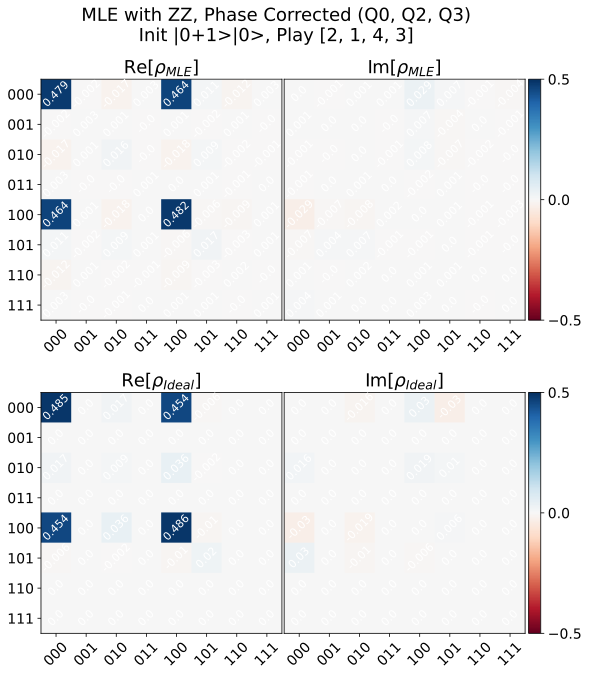


init_state |0>|0+1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.8824474172650003
Purity (after rotation): 0.714661713305508
Target purity: 0.9397417449962346


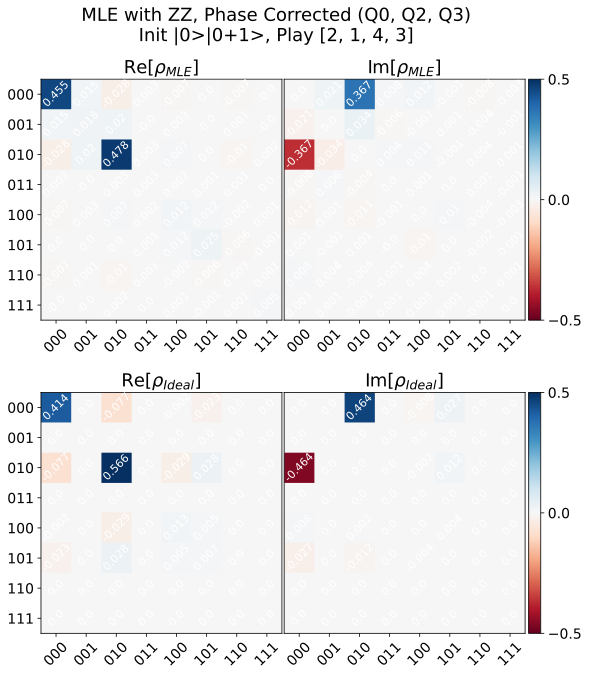


init_state |1>|0+1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9413609372553765
Purity (after rotation): 0.8629428208360683
Target purity: 0.9432438831648384


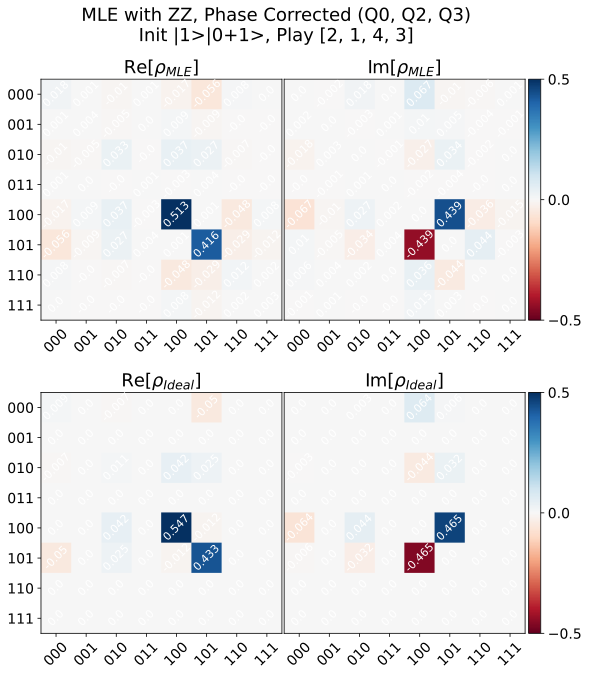


init_state |0+1>|1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.8987211962183853
Purity (after rotation): 0.8086306223927182
Target purity: 0.8767118509522733


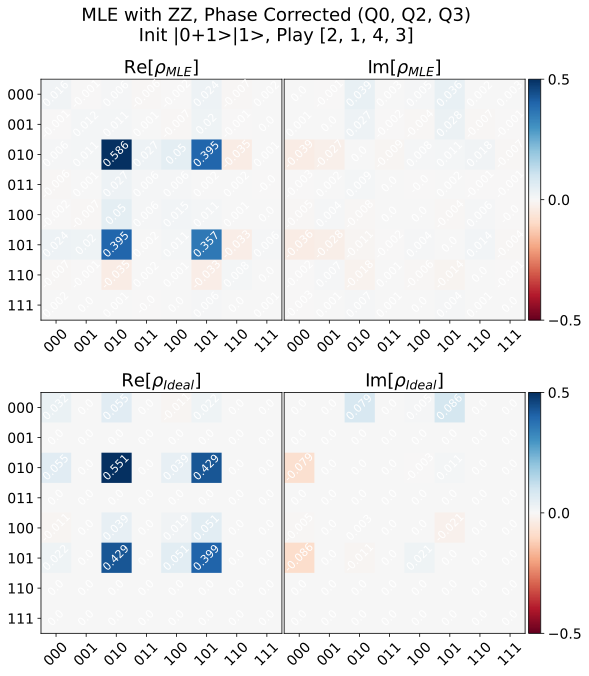


init_state |0+1>|0+1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9015256108107746
Purity (after rotation): 0.7751186664067808
Target purity: 0.9446851641931322


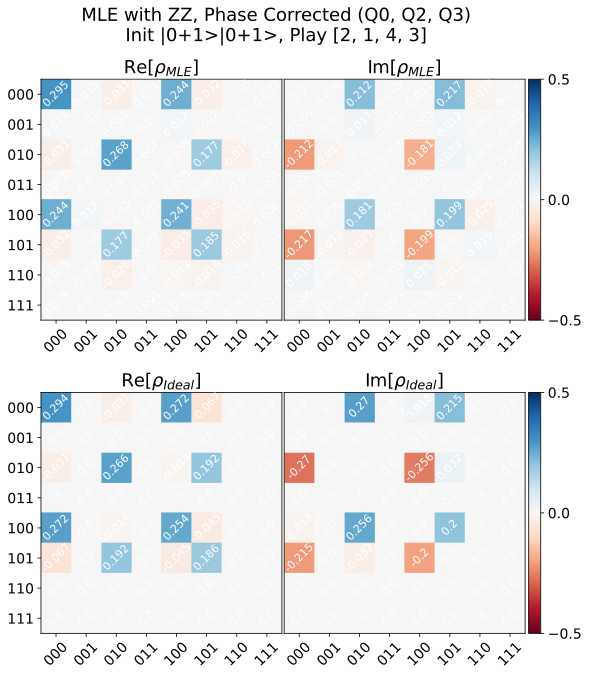


init_state |0>|0>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9772957661087489
Purity (after rotation): 0.9383767979104932
Target purity: 0.9631241541368141


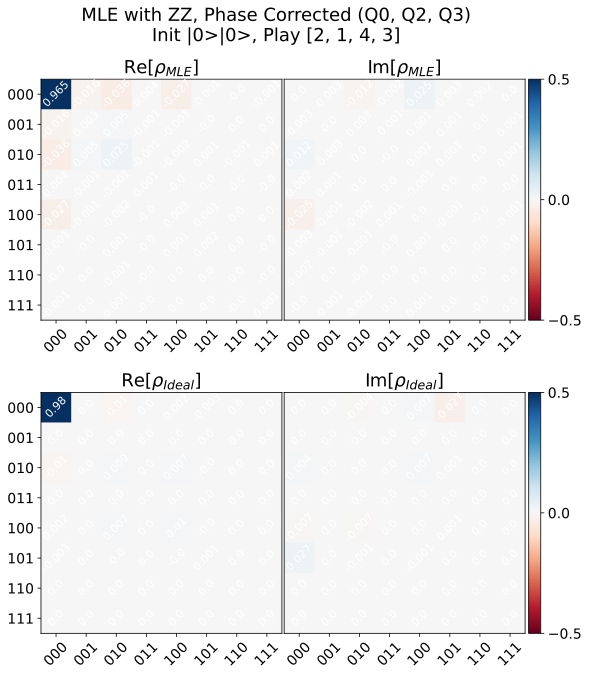


init_state |1>|0>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9630567514050167
Purity (after rotation): 0.9427824063597159
Target purity: 0.9164425159009308


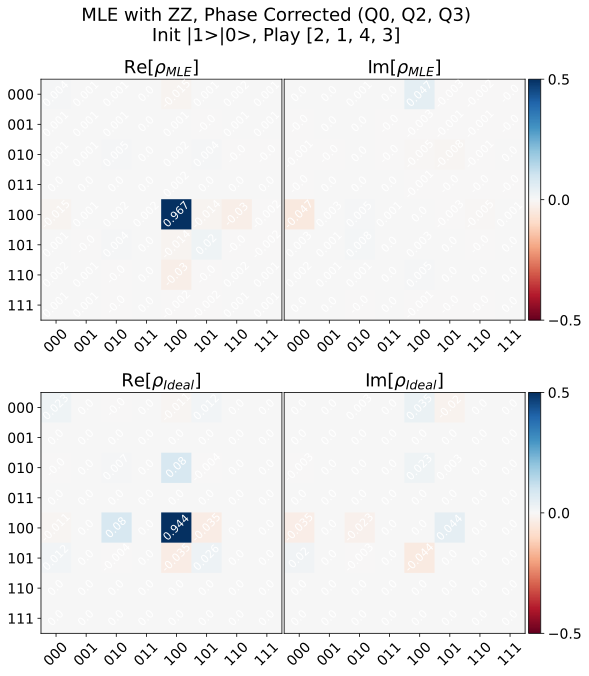


init_state |1>|1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.8689228936274315
Purity (after rotation): 0.806058327070992
Target purity: 0.9145833875813151


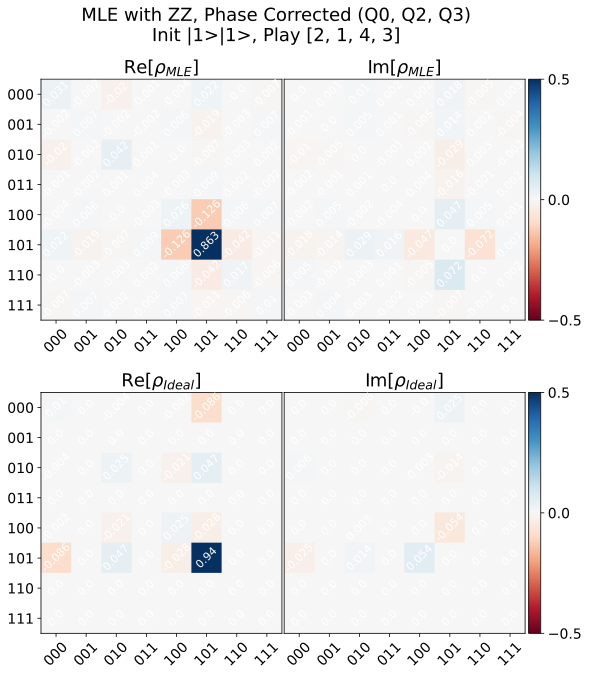


init_state |0>|1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.8759378874364697
Purity (after rotation): 0.7547414434850718
Target purity: 0.9384887100288656


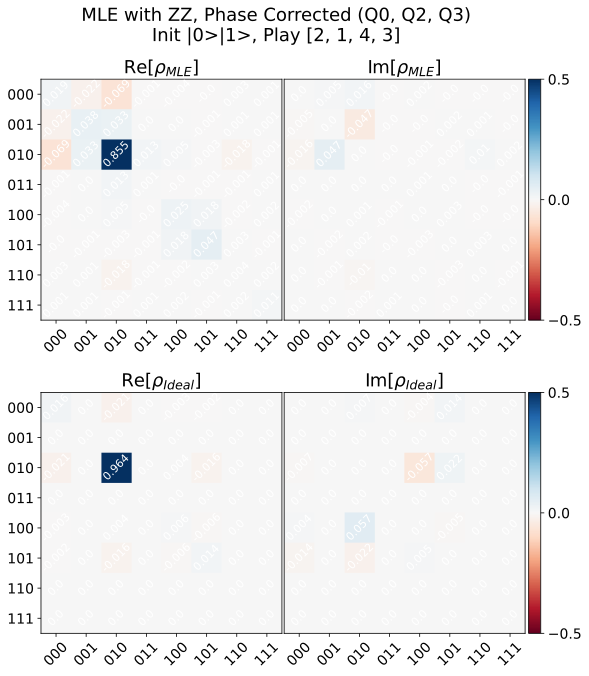

In [83]:
use_ZZ_mat = True

# Pick best overall phi

phis[0] = np.linspace(0, 360, 30) # Q0
# phis[0] = [0] # Q00
phis[1] = np.linspace(0, 360, 30) # Q2
phis[2] = np.linspace(0, 360, 30) # Q3

# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0>', '|0+1>|0+1>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>']
# check_init_states = ['|0+1>|0+1>']
check_init_states = init_states
    

fids_grids_reshaped = []
for i_state in range(len(init_states)):
    grid_shape = fids_grids[i_state].shape
    print(grid_shape)
    fids_grid = np.copy(fids_grids[i_state]).tolist()
    # print(init_states[i_state], grid_shape)
    if grid_shape[0] == 1:
        for i in range(grid_shape[1]-1):
            fids_grid.append(fids_grid[0])
    # print(np.array(fids_grid).shape)
    fids_grids_reshaped.append(fids_grid)

fids_grids_reshaped = np.array(fids_grids_reshaped)
print(fids_grids_reshaped.shape)


best_avg_fid = 0
best_fids = []
best_phis = [0, 0, 0]
best_phi_indices = [0, 0, 0]
for iphi0, phi0 in enumerate(phis[0]):
    for iphi1, phi1 in enumerate(phis[1]):
        for iphi2, phi2 in enumerate(phis[2]):
            avg_fid = 0
            for i_state, init_state in enumerate(init_states):
                if init_state not in check_init_states: continue
                avg_fid += fids_grids_reshaped[i_state][iphi0, iphi1, iphi2]
            avg_fid /= len(check_init_states)
            if avg_fid > best_avg_fid:
                best_phis = [phi0, phi1, phi2]
                best_phi_indices = [iphi0, iphi1, iphi2]
                best_avg_fid = avg_fid

for i_state, init_state in enumerate(init_states):
    if init_state not in check_init_states: continue
    best_fids.append(fids_grids_reshaped[i_state][best_phi_indices[0], best_phi_indices[1], best_phi_indices[2]])

print('best avg fid', best_avg_fid)
print('best fids for check states', best_fids)
print('best phis', best_phis)

z_phi123 = z_gate_3q(*best_phis)

print()
for i_state, init_state in enumerate(init_states):
    if init_state not in check_init_states: continue
    print('init_state', init_state)
    # init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
    init_rho = rho_MLE_ZZ_dict[init_state]
    rho_id = get_qram_qSLR_state_from_rho(init_rho)
    
    if use_ZZ_mat: rho_MLE_rot = (z_phi123*qt.Qobj(rhos_ZZ[i_state], dims=rho_id.dims)*z_phi123.dag()).unit()
    else: rho_MLE_rot = (z_phi123*qt.Qobj(rhos_base[i_state], dims=rho_id.dims)*z_phi123.dag()).unit()
    fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2
    
    purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    print(f'Fidelity (after rotation): {fid_rot}')
    print(f'Purity (after rotation): {purity_MLE_rot}')
    print(f'Target purity: {purity_id}')
    
    if saveplots: savetitle=saved_file[:-3]+f'{"_ZZcorrect" if use_ZZ_mat else ""}_optrot{save_append}.svg'
    else: savetitle = None
    show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE {"with ZZ" if use_ZZ_mat else "Base"}, Phase Corrected (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})\nInit {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    print()

## Run analysis

### Reopen old data

In [ ]:
filename = 'S:\Connie\experiments\qramLL_4QR2\data\data_240617\\00006_QramProtocol3QTomo.h5'
# data, attrs = prev_data(expt_path, '00009_QramProtocol3QTomo.h5')
saved_files.append(filename)
data, attrs = prev_data(filename, None)
pulse_dict = attrs['pulse_dict']
print('calib_order', attrs['calib_order'])
print('meas_order', attrs['meas_order'])

print(data.keys())
# # data = None
# # style.use('default')
# # qramExpt.analyze(data=data)
# # qramExpt.display(data=data, err=False, saveplot=True)
# # print(data)

cfg = AttrDict(attrs['config'])
init_state = cfg.expt.init_state
play_pulses = cfg.expt.play_pulses
tomo_qubits = cfg.expt.tomo_qubits
print('init_state', init_state)
print('play_pulses', play_pulses)
print('tomo_qubits', tomo_qubits)

np.set_printoptions(suppress=True)
n_tomo_raw = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])
n_tomo_corrected = fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))
n_tomo = n_tomo_corrected
# print('n_tomo')
# print(n_tomo)
print('counts_calib')
print(data['counts_calib'])
print(attrs['calib_order'])

print(f'thresholds={data["thresholds"].tolist()},')
print(f'angles={data["angles"].tolist()},')
print(f'ge_avgs={data["ge_avgs"].tolist()}',',')
print(f'counts_calib={data["counts_calib"].tolist()}')

In [ ]:
# # counts_calib = data['counts_calib']
# counts_calib=[array([3189,  426, 3176,  519, 1176,  198, 1110,  206]), array([ 580, 3047,  582, 3015,  207, 1148,  221, 1200]), array([1963,  289, 4456,  583,  721,   97, 1661,  230]), array([ 390, 1850,  812, 4372,  130,  683,  269, 1494]), array([1336,  209, 1293,  232, 2954,  473, 2981,  522]), array([ 256, 1341,  226, 1320,  512, 2924,  557, 2864]), array([ 809,  118, 1892,  295, 1810,  262, 4215,  599]), array([ 167,  796,  352, 1830,  325, 1776,  781, 3973])]


# # introduce gaussian noise
# np.random.seed(0)
# noise = 2.0
# n = np.copy([counts_calib[4]])
# print(n, sum(n))
# n0 = correct_readout_err(n, n_conf=counts_calib)
# print('correct readout err', n0)
# print('fix neg counts', fix_neg_counts(n0))

# if noise is not None:
#     for n_psi in n:
#         n_meas = sum(n_psi)
#         new_nlast = -1
#         while new_nlast < 0:
#                 new_n_uptolast = np.random.normal(loc=n_psi[:-1], scale=noise*np.sqrt(n_psi[:-1]))
#                 # new_n_uptolast *= 1 - np.isnan(new_n_uptolast) # 0 out the nans
#                 # print('here', new_n_uptolast)
#                 # preserve original total count per measurement
#                 new_nlast = n_meas - sum(new_n_uptolast)
#                 n_psi[:-1] = np.round(new_n_uptolast)
#                 n_psi[-1] = np.round(new_nlast)

# print(1)
# print(n, sum(n))
# print(type(n))
# print(np.shape(n))
# print(n[0].dtype)
# n = np.array(n, dtype=float)
# n1 = correct_readout_err(n, n_conf=counts_calib)
# print('correct readout err', n1)
# print('fix neg counts', fix_neg_counts(n1))


# # print('n1-n2')
# # print(n1-n2)

# print(3)
# n = [[ 287, 1291,  675, 2954,  256, 1250,  554, 2733]]
# print(n)
# n = correct_readout_err(n, n_conf=counts_calib)
# print(sum(n))
# print(fix_neg_counts(n))

# print(4)
# correct_readout_err(counts_calib, counts_calib)

### Set ideal rho

Get ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [32]:
# Define the basis of psis

psiZ = [qt.basis(2,0), qt.basis(2,1)]
psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(calib_order_numeric):
    psis.update({label_numeric:psi_basis['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

In [33]:
def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i1':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i1':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
def get_qram_qSLR_state_from_rho(init_rho_SI, post_select=False, post_select_state=None):
    """
    init_rho_SI should be a np array
    """
    # in order |00>, |01>, |10>, |11> for Q0 (switch), Q1 (input)
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.shape(init_rho_SI) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    print('constructing final state on |switch, out1, out2>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_SI[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    return rho_final_SLR.unit()

### Get final qram state from an arbitrary 2Q input density matrix

In [61]:
print('init state Q0 (switch) Q1 (input):', init_state)

# init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
# if init_state == '|0+1>|0+1>':
#     init_rho = np.array([[(0.23+0j), (0.057+0.233j), (0.18-0.099j), (-0.078+0.08j)], [(0.057-0.233j), (0.287+0j), (-0.016-0.171j), (-0.013+0.114j)], [(0.18+0.099j), (-0.016+0.171j), (0.266+0j), (-0.166+0.121j)], [(-0.078-0.08j), (-0.013-0.114j), (-0.166-0.121j), (0.217+0j)]])
# init_rho = qt.ket2dm((name_to_state_2q('|1>|0>') + name_to_state_2q('|1>|1>') + name_to_state_2q('|0>|0>') + 1j*name_to_state_2q('|0>|1>')).unit())

# rho_id = get_qram_qSLR_state_from_rho(init_rho)
# rho_id


# # rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\202402281619_init_rhoMLE_ZZ_2Q_01.npz'
# rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\202402291250_init_rhoMLE_ZZ_2Q_01.npz'

# print(f'Using rho_MLE_ZZ for Q0/Q1 from file {rho_MLE_ZZ_2Q_filepath}')

# rho_MLE_ZZ_dict = dict()
# with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
#     for key in npzfile.keys():
#         rho_MLE_ZZ_dict.update({key:npzfile[key]})
# print(f'rho_MLE_ZZ retrieved with init_states {rho_MLE_ZZ_dict.keys()}')
init_rho = rho_MLE_ZZ_dict[init_state]
rho_id = get_qram_qSLR_state_from_rho(init_rho)

init state Q0 (switch) Q1 (input): |0>|1>
constructing final state on |switch, out1, out2>


In [ ]:
# psi_id = qt.tensor(psiZ[1]+psiZ[0], psiZ[0], psiZ[1]+psiZ[0]).unit()
# psi_id = qt.tensor(psiZ[1], psiZ[0], psiZ[1]).unit()
# rho_id = qt.ket2dm(psi_id)
rho_id = qt.ket2dm(psis['010'] + psis['011']).unit()
# print(rho_id.dims)

### Generate test data

In [ ]:
# rho_id = qt.ket2dm(psi10 + psi11).unit()

# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
n_tomo_sim = generate_counts(rho_id=rho_id, n_tot=100000, evol_mats=evol_mats, noise=None)
# n_tomo = generate_counts(rho_id=rho_MLE_ZZ, n_tot=100000, evol_mats=evol_mats, noise=None)
# n_tomo = n_tomo_sim
print(n_tomo_sim)

print(meas_order)
print(calib_order)
print('difference')
print(np.round((n_tomo_sim - n_tomo)/100000, 2))

In [ ]:
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, evol_mats=evol_mats, noise=None)
# n_calib = qt.qeye(4).full()
# print(fix_neg_counts(n_tomo))

### Run MLE without ZZ correction

In [ ]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
# rho_MLE_base = run_MLE(n=n_tomo, rho_id=rho_id, ZZ_correction=False, method='L-BFGS-B')
rho_MLE_base = run_MLE_analytical(n=n_tomo, ZZ_correction=False)

print(rho_MLE_base)

In [ ]:
fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', cmax=0.5)

print('Saved data:')
print(*saved_files)

### Run MLE with ZZ

#### Get evol mats for ZZ

In [40]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [ ]:
# Recover old config
yaml_cfg = AttrDict(attrs['config'])

In [41]:
evol_mats_path = os.path.join(os.getcwd(), 'evol_mats')
print('Will save evol mats to path', evol_mats_path)

qA, qB, qC = tomo_qubits
evol_mats_filename = f'evol_mats_{qA}{qB}{qC}.npz'
print('Will save to filename', evol_mats_filename)

Will save evol mats to path S:\Connie\experiments\qramLL_4QR2\evol_mats
Will save to filename evol_mats_023.npz


In [42]:
f_ge = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ge]) # MHz
f_ef = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ef]) # Mhz
# gs = np.array([51, 51, 36, 9, 8, 3.5]) # MHz

qA, qB, qC = tomo_qubits
print('TOMO QUBITS', tomo_qubits)
ZZs_4q = np.zeros((4,4))
reshaped_f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
for row in range(4):
    ZZs_4q[row,:] = reshaped_f_ge[row,:] - reshaped_f_ge[row,row]

f_ge = np.array([f_ge[qA], f_ge[qB], f_ge[qC]])
f_ef = np.array([f_ef[qA], f_ef[qB], f_ef[qC]])
alphas = f_ef - f_ge # MHz
ZZs = np.zeros(shape=(3, 3))
ZZs = ZZs_4q[tomo_qubits][:,tomo_qubits]

# ZZs = 0*ZZs
# ZZs = 10*ZZs

print('qubit freqs', f_ge)
# print('alphas', alphas)
print('ZZs (MHz)', ZZs)
# print(pulse_dict)

print('Will save to filename', evol_mats_filename)

evol_mats = get_evol_mats(qubits=tomo_qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, ZZs=ZZs*1e-3, pulse_dict=pulse_dict, debug=False)
# evol_mats = get_evol_mats(qubits=qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, gs=gs*1e-3, pulse_dict=pulse_dict)

# print(evol_mats)

evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
np.savez(evol_mats_file_path, **evol_mats)
print(f'Saved evol mats to file {evol_mats_file_path}')

TOMO QUBITS [0, 2, 3]
qubit freqs [4110.56833467 4762.24907399 4380.77579257]
ZZs (MHz) [[ 0.         -0.10430714 -0.5526523 ]
 [-0.10430714  0.         -0.48324089]
 [-0.5526523  -0.52759174  0.        ]]
Will save to filename evol_mats_023.npz


Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\2398425812.py: 25

  0%|          | 0/27 [00:00<?, ?it/s]

Saved evol mats to file S:\Connie\experiments\qramLL_4QR2\evol_mats\evol_mats_023.npz


#### Reload evol mats

In [ ]:
qA, qB, qC = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
# evol_mats_file_path = os.path.join(evol_mats_path, f'evol_mats_{qA}{qB}{qC}_test.npz')
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})
# print(evol_mats)

#### Actually run MLE with ZZ correction

In [65]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
# rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_MLE_base, rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
# rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_from_counts(n_tomo), rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats) #, method='Powell')
rho_MLE_ZZ = run_MLE_analytical(n=n_tomo, ZZ_correction=True, evol_mats=evol_mats) #, method='Powell')
# rho_MLE_ZZ = run_MLE(n=fix_neg_counts(correct_readout_err(n_tomo, n_calib)), rho_guess=rho_MLE_base, rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)

 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\1190206765.py: 15ComplexWarning: Casting complex values to real discards the imaginary part
 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\1190206765.py: 20

In [66]:
# GET IDEAL RHO FROM DICTIONARY
print('init state to get ideal rho', init_state)
init_rho = rho_MLE_ZZ_dict[init_state]
rho_id = get_qram_qSLR_state_from_rho(init_rho)

init state to get ideal rho |0+1>|1>
constructing final state on |switch, out1, out2>


[[ 0.04 -0.j    -0.004+0.004j  0.047+0.j     0.005+0.001j  0.007+0.008j
   0.044+0.03j  -0.003+0.004j -0.002+0.j   ]
 [-0.004-0.004j  0.007-0.j     0.032+0.014j -0.003-0.j    -0.001-0.005j
   0.019+0.032j -0.004+0.001j -0.   +0.001j]
 [ 0.047-0.j     0.032-0.014j  0.54 +0.j     0.015-0.005j  0.033+0.042j
   0.29 +0.26j  -0.029+0.038j -0.001-0.004j]
 [ 0.005-0.001j -0.003+0.j     0.015+0.005j  0.006-0.j     0.003+0.009j
   0.   -0.002j  0.   +0.001j  0.   +0.j   ]
 [ 0.007-0.008j -0.001+0.005j  0.033-0.042j  0.003-0.009j  0.022-0.j
   0.012+0.009j  0.003+0.002j -0.001-0.001j]
 [ 0.044-0.03j   0.019-0.032j  0.29 -0.26j   0.   +0.002j  0.012-0.009j
   0.379+0.j    -0.004+0.035j -0.003+0.005j]
 [-0.003-0.004j -0.004-0.001j -0.029-0.038j  0.   -0.001j  0.003-0.002j
  -0.004-0.035j  0.006-0.j    -0.   +0.j   ]
 [-0.002-0.j    -0.   -0.001j -0.001+0.004j  0.   -0.j    -0.001+0.001j
  -0.003-0.005j -0.   -0.j     0.001-0.j   ]]
Fidelity (with ZZ correction): 0.8009658799958728
Purity (with ZZ 

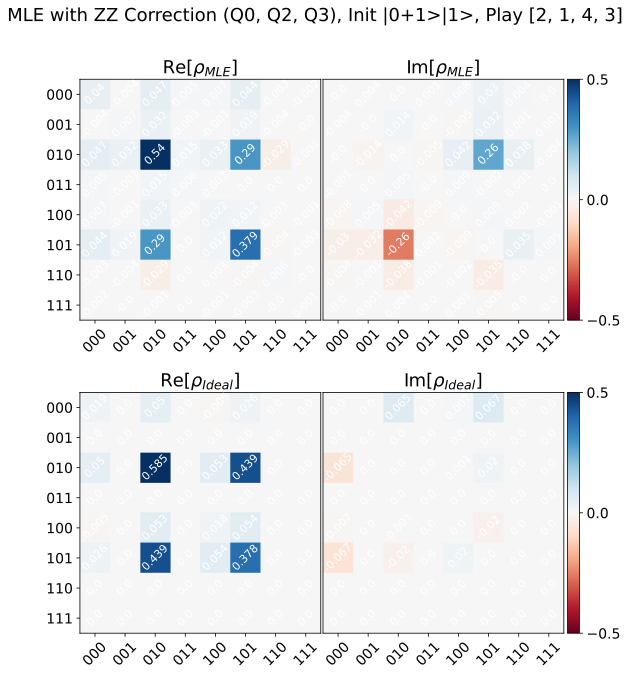

Saved data:
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00033_QramProtocol3QTomo.h5


In [67]:
print(np.around(rho_MLE_ZZ, decimals=3))
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None

if savetitle is None: plt.style.use('default')
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
print('init state', init_state)
show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)

if save_data:
    print('Saved data:')
    print(saved_files[-1])

### Optimize over virtual Z gates on ideal rho 

Optimize over virtual Z gates on ideal rho 

In [68]:
# rho_MLE = rho_MLE_base
rho_MLE = rho_MLE_ZZ

In [69]:
phis = [None, None, None]
phis[0] = np.linspace(0, 360, 40)
phis[1] = np.linspace(0, 360, 40)
phis[2] = np.linspace(0, 360, 40)
# phis[0] = np.linspace(0, 360, 1)
# phis[1] = np.linspace(0, 360, 100)
# phis[2] = np.linspace(0, 360, 100)

rho_MLE_rot, best_phis, best_fid, fids_grid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
print('Rotation:', best_phis)

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\425015463.py: 13

  0%|          | 0/40 [00:00<?, ?it/s]

Improved fidelity by (%) 11.465662672047639
Rotation: [101.53846153846153, 286.15384615384613, 221.53846153846152]


phi Q0 101.53846153846153
fid at phi2=286.15384615384613, phi3=221.53846153846152: 0.9156225067163491
Saved S:\Connie\experiments\qramLL_4QR2\data\data_240617\00033_QramProtocol3QTomo.svg


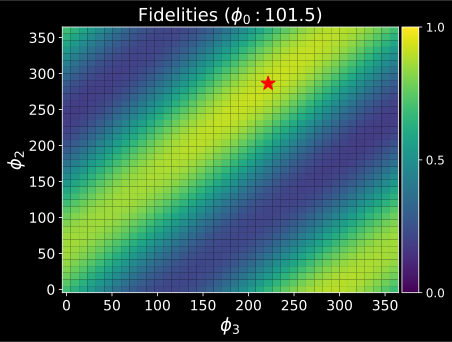

In [70]:
inner_sweep = phis[2]
outer_sweep = phis[1]
y_sweep = outer_sweep
x_sweep = inner_sweep

# vmax = np.max(fids_grid)
vmax = 1.0

# best_phis =  [350.7692307692307, 304.6153846153846, 138.46153846153845]
# best_phis =  [115, 350, 203]
# best_phis = [350.7692307692307, 18.46153846153846, 258.46153846153845]

saveplot = True
plot_filename = filename[:-3]+'.svg'
if saveplot: plt.style.use('dark_background')
best_phi_inds = [np.argmin(np.abs(phis[i]-best_phis[i])) for i in range(3)]

for i_phi0, phi0 in enumerate(phis[0]):
    if i_phi0 != best_phi_inds[0]: continue 
    print(f'phi Q0 {phi0}')
    plt.figure()
    plt.title(f'Fidelities ($\phi_0: ${phi0:0.4})', fontsize=18)
    plt.xlabel(f'$\phi_{tomo_qubits[2]}$', fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel(f'$\phi_{tomo_qubits[1]}$', fontsize=18)
    plt.yticks(fontsize=14)
    plt.pcolormesh(y_sweep, x_sweep, fids_grid[i_phi0], cmap='viridis', shading='auto')
    
    plt.plot([best_phis[2]], [best_phis[1]], 'r', marker='*', markersize=15)
    print(f'fid at phi2={best_phis[1]}, phi3={best_phis[2]}:', fids_grid[i_phi0][best_phi_inds[1]][best_phi_inds[2]])
    
    # old_best_phis = [0.0, 94.54545454545455, 349.09090909090907]
    # old_best_phis = [0.0, 196.36363636363635, 341.8181818181818]
    # plt.plot([old_best_phis[2]], [old_best_phis[1]], 'r', marker='o')
    
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, vmax])
    # cbar.ax.set_title(f'Fidelity')
    cbar.ax.tick_params(labelsize=12)
    plt.clim(vmin=0, vmax=vmax)
    
    if saveplot:
        plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
        print('Saved', plot_filename)
        
    plt.show()
    
# print(f'Difference between phi0[0] and phi0[1]')
# plt.figure()
# plt.title(f'Difference in fidelities ($\phi_0: $0 vs 30)')
# plt.xlabel(f'phis Q{tomo_qubits[2]}')
# plt.ylabel(f'phis Q{tomo_qubits[1]}')
# plt.pcolormesh(y_sweep, x_sweep, fids_grid[0]-fids_grid[1], cmap='viridis', shading='auto')

# # plt.plot([best_phis[2]], [best_phis[1]], 'r', marker='o')

# # old_best_phis = [0.0, 94.54545454545455, 349.09090909090907]
# # old_best_phis = [0.0, 196.36363636363635, 341.8181818181818]
# # plt.plot([old_best_phis[2]], [old_best_phis[1]], 'r', marker='o')

# plt.colorbar()
# # plt.clim(vmin=0, vmax=1)
# plt.show()

Fidelity (after rotation): 0.9156225067163491
Purity (after rotation): 0.7707817822307648
Target purity: 0.9088005114346163
Best rotation: [101.53846153846153, 286.15384615384613, 221.53846153846152]


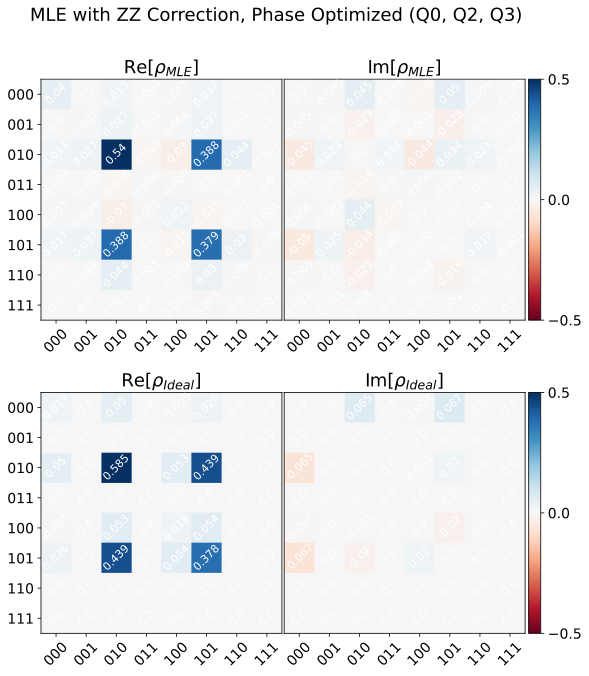

Saved data
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00033_QramProtocol3QTomo.h5


In [72]:
# best_phis = [0.0, 170.9090909090909, 254.54545454545453]
# best_phis = [0.0, 272.7272727272727, 167.27272727272728]
# best_phis = old_best_phis

z_phi123 = z_gate_3q(*best_phis)
rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
savetitle=None
# savetitle=saved_file[:-3]+f'_ZZcorrect_optrot.svg'
show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)
print('Saved data')
print(saved_files[-1])

# Loop over 2Q sweep parameters

In [ ]:
# gain_sweep = np.linspace(2000, 25000, 11)
# opt_lens = 1e3*np.array([2.4201237152470587, 1.1987019004033739, 0.7868408797215013, 0.5851160587684981, 0.4716335769416996, 0.3999234927074055, 0.34781134410506404, 0.3089041362621608, 0.2818412962269934, 0.2636215545192442, 0.2512183319921639])
# opt_freqs = [5891.5, 5891.325, 5890.9, 5890.35, 5889.675, 5888.875, 5887.95, 5887.15, 5886.1, 5885.55, 5884.5]


gain_sweep = np.linspace(18000, 32000, 11)
opt_freqs = [5887.35, 5886.616666666667, 5885.883333333333, 5885.616666666667, 5885.116666666667, 5884.383333333333, 5884.116666666667, 5883.616666666667, 5882.883333333333, 5882.383333333333, 5882.583333333333]
opt_lens = [0.30514258121790533, 0.28952631508344284, 0.27703044436306967, 0.2646698856191053, 0.25368901625658447, 0.24735611563570364, 0.23874769989670325, 0.23044507614293083, 0.22816368954972915, 0.22170985331767395, 0.20962837376879714]

save_data = True
sweep2Q_q = 2
qubit = 2
play_pulses=[1,3]

In [ ]:
saved_files = []

init_state = '|0+1>|1>'

opt_phis = [None]

thresholds = None
angles = None
ge_avgs = None
counts_calib = None


for i_gain, gain in enumerate(gain_sweep):
    
    tomo = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    tomo.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
        reps=30000, # number of reps per tomo/time step,
        singleshot_reps=30000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_3q=True,
        tomo_qubits=tomo_qubits,
        init_state=init_state,
        play_pulses=play_pulses,
        thresholds=thresholds,
        angles=angles,
        ge_avgs=ge_avgs,
        counts_calib=counts_calib,
    )
    tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_lens[i_gain]
    tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freqs[i_gain]
    print('gain', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q],
          'len', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q],
          'freq', tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q])
    try:
        tomo.go(analyze=False, display=False, progress=False, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(tomo.save_data())
    data = tomo.data
    if i_gain == 0:
        thresholds = data['thresholds']
        angles = data['angles']
        ge_avgs = data['ge_avgs']
        counts_calib = data['counts_calib']
    
    print()

In [ ]:
print(saved_files)

In [ ]:
print(saved_files)

### Calculate fidelities with ZZ correction and phase optimization

In [ ]:
all_n_tomo = []
all_n_calib = []
all_fids = []
all_fids_rot = []

rho_id = qt.ket2dm(psis['001'] + psis['110']).unit()

for saved_file in saved_files:
    saved_file = saved_file.split('\\')
    # print(saved_file)
    data, attrs = prev_data(expt_path, saved_file[-1])
    pulse_dict = attrs['pulse_dict']
    n_tomo = np.array(data['counts_tomo'])
    n_calib = np.array(data['counts_calib'])

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)

    # rho_MLE = run_MLE(n=correct_readout_err(n_tomo, n_calib), method='L-BFGS-B')
    # show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)
    rho_MLE = run_MLE(n=n_tomo, rho_guess=rho_from_counts(n_tomo), rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
    # show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"

    all_fids.append(fid_base)
    print('fid base', fid_base)
    
    rho_MLE_rot, best_phis, fid_rot = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
    all_fids_rot.append(fid_rot)
    show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=None, cmax=0.5)
    print('fid rot', fid_rot)
    


In [ ]:
# print(all_n_tomo)
# print(all_n_calib)
# print(all_fids)
print('fidelity with optimized rotation\n', all_fids_rot)
print('saved files\n', saved_files)

In [ ]:
plt.plot(opt_lens, all_fids_rot, label='Q2 measured fidelity')

# decay_time = 10e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

# decay_time = 1e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

plt.xlabel(f'Length of 2Q swap in full protocol (ns)')
plt.ylabel(f'Q{sweep2Q_q} Fidelity')
plt.title(f'Q{sweep2Q_q}/Q1 parameter sweep from initial state {init_state}')
plt.legend()
plt.show()